In [117]:
from PIL import Image
import numpy as np
import math

In [118]:
class camera:
    """ An class that contains all the data for a camera """
    def __init__(self, horizontal_fov: int, vertical_fov: int, resolution: tuple, location: tuple, direction: tuple, view_distance: tuple):
        self.horizontal_fov = horizontal_fov
        self.vertical_fov = vertical_fov
        self.resolution = resolution
        self.location = location
        self.direction = direction
        self.view_distance = view_distance

In [119]:
class mesh3D:
    """ An class that contains all the data for a mesh """
    def __init__(self, verticies: list, faces: list, center: tuple):
        self.verticies = verticies
        self.faces = faces
        self.center = center

In [120]:
def save_image(pixels: list, image_name: str):
    """takes in a numpy array of tuples of rgb values and converts it into a image then it saves the image as a file and displays the image"""
    pixels = list(zip(*pixels))[::-1]
    array = np.array(pixels, dtype=np.uint8)
    new_image = Image.fromarray(array)
    display(new_image)
    new_image.save(image_name + '.png')

In [121]:
def initialize_2dimage(dimensions: tuple, background_color: tuple) -> list:
    ''' Creates a three dimensional numpy array of a certain size that dimension1 x dimension2 x 3 to represent the RGB value at each point'''
    image = np.zeros((1000, 1000, 3), dtype=np.uint8)
    image[:, :, 0] = background_color[0] 
    image[:, :, 1] = background_color[1] 
    image[:, :, 2] = background_color[2] 
    return image

In [122]:
def line_2d(point_1: np.ndarray, point_2: np.ndarray):
    """ 
    Acts as a generator which yields the the cordinates of subsequent points on a line formed between two inputed points as tuples

    SPECIAL INFORMATION
    - Lines include both end points
    -only one pixel per line in the direction which moves the most over time 
        - EX: (0,0) to (5,20) there would only every be one box per y value
    """

    x1, y1 = point_1
    x2, y2 = point_2

    #preparation calculations (differences and direction)
    difference_x = abs(x2 - x1)
    difference_y = abs(y2 - y1)
    if x2 > x1:
        x_sign = 1
    else:
        x_sign = -1
    if y2 > y1:
        y_sign = 1
    else:
        y_sign = -1

    if difference_x > difference_y: # senario when the x value changes more than y in the line
        y_error = 2*difference_y - difference_x
        yield (int(x1),int(y1))
        while x1 != x2:
            x1 += x_sign
            if y_error >= 0:
                y1 += y_sign
                y_error -= 2 * difference_x
            y_error += 2 * difference_y 
            yield (int(x1),int(y1))

    else: # senarion when y changes more than x or both change the exact same amount
        x_error = 2*difference_x - difference_y
        yield (int(x1),int(y1))
        while y1 != y2:
            y1 += y_sign
            if x_error >= 0:
                x1 += x_sign
                x_error -= 2 * difference_y
            x_error += 2 * difference_x 
            yield (int(x1),int(y1))

In [123]:
def global_cords(center: np.ndarray, model_verticies: np.ndarray):
    """Will return location of a meshes verticies in global space from inputtings its center location and mesh information"""
    transformation_matrix = np.array([[1,0,0,center[0]],
                                      [0,1,0,center[1]],
                                      [0,0,1,center[2]],
                                      [0,0,0,1]])
    return [np.dot(transformation_matrix,vertex) for vertex in model_verticies]

In [124]:
def reorient_to_camera(cam: camera, global_verticies: np.ndarray):
    """reorients and rotates verticies to be aligned with the camera at (0,0) with the positive direction where the camera is looking"""
    translation_matrix = np.array([[1,0,0,-cam.location[0]],
                                    [0,1,0,-cam.location[1]],
                                    [0,0,1,-cam.location[2]],
                                    [0,0,0,1]])
    x_rotation_matrix = np.array([[1,0,0,0],
                                  [0,math.cos(math.radians(-cam.direction[0])),-math.sin(math.radians(-cam.direction[0])),0],
                                  [0,math.sin(math.radians(-cam.direction[0])),math.cos(math.radians(-cam.direction[0])),0],
                                  [0,0,0,1]])
    y_rotation_matrix = np.array([[math.cos(math.radians(-cam.direction[1])),0,math.sin(math.radians(-cam.direction[1])),0],
                                  [0,1,0,0],
                                  [-math.sin(math.radians(-cam.direction[1])),0,math.cos(math.radians(-cam.direction[1])),0],
                                  [0,0,0,1]])
    z_rotation_matrix = np.array([[math.cos(math.radians(-cam.direction[2])),-math.sin(math.radians(-cam.direction[2])),0,0],
                                  [math.sin(math.radians(-cam.direction[2])),math.cos(math.radians(-cam.direction[2])),0,0],
                                  [0,0,1,0],
                                  [0,0,0,1]])
    return [np.dot(np.dot(np.dot(np.dot(point,translation_matrix),x_rotation_matrix),y_rotation_matrix),z_rotation_matrix) for point in global_verticies] 

In [125]:
############ POTENTIALLY REMOVE THIS IF CLIPPING IN THE RASTERIZATION FUNCTION WORKS WELL ENOUGH############
def clipping(cam: camera, camera_space_verticies: np.ndarray, faces: np.ndarray):
    ''' takes in verticies location in respect to the camera and runs through each face to determine if it is in the fov of the camera. If none of the face is in the camera it will get deleted'''
    remaining_faces = []
    for face in faces:
        for point_idx in face:
            point = camera_space_verticies[point_idx]
            if cam.horizontal_fov >= abs(math.degrees(math.tan(point[0]/point[2]))) and cam.vertical_fov >= abs(math.degrees(math.tan(point[1]/point[2]))) and cam.view_distance[1] >= point[2] >= cam.view_distance[0]:
                remaining_faces.append(face)
                break
    return np.asarray(remaining_faces)

In [126]:
def perspective_projection(cam: camera, oriented_to_camera_vertices: np.ndarray):

    projection_matrix = np.array([
        [cam.view_distance[0] / math.tan(math.radians(cam.horizontal_fov / 2)), 0, 0, 0],
        [0, cam.view_distance[0] / math.tan(math.radians(cam.vertical_fov / 2)), 0, 0],
        [0, 0, cam.view_distance[1] - cam.view_distance[0], -cam.view_distance[0] * cam.view_distance[0]],
        [0, 0, 1, 0]])

    points_in_2d = []
    for vertex in oriented_to_camera_vertices:
        homogeneous_point = np.dot(vertex, projection_matrix)
        w_reciprocal = 1.0 / homogeneous_point[3]

        # Avoid creating unnecessary NumPy array, use a temporary variable instead
        projected_point = [homogeneous_point[0] * w_reciprocal, homogeneous_point[1] * w_reciprocal, homogeneous_point[3], 1]
        points_in_2d.append(projected_point)

    return np.asarray(points_in_2d)


In [127]:
def back_culling(verticies_2d: np.ndarray, faces: np.ndarray):
    ''' takes in faces and verticies and returns a list of faces excluding any faces that would be looking away from the camera and occluded by other faces in front of it'''
    culled_faces = []
    for face in faces:
        ax, ay, az, _ = verticies_2d[face[0]]
        bx, by, bz, _  = verticies_2d[face[1]]
        cx, cy, cz, _  = verticies_2d[face[2]]
        #relies on any mesh textextures to have their faces to have vectors cross product face out of the mesh
        vector1 = np.array([bx-ax, by-ay, bz-az]) 
        vector2 = np.array([bx-cx, by-cy, bz-cz])
        angle = np.cross(vector1, vector2)
        if np.dot(angle, verticies_2d[face[1], :2]) < 0:
            culled_faces.append(face)
    return np.asarray(culled_faces)

In [128]:
def screen_space(cam: camera, verticies: np.ndarray):
    ''' Takes in verticies after the perspective projection and adjusts them to the resolution of the screen '''
    return np.array([[round((vertex[0]+1)*cam.resolution[0]/2),round((vertex[1]+1)*cam.resolution[1]/2),vertex[2],1] for vertex in verticies])

In [129]:
def mesh_to_screen_space (cam: camera, mesh: mesh3D):
    global_verticies = global_cords(mesh.center, mesh.verticies)
    camera_space_verticies = reorient_to_camera(cam, global_verticies)
    clipped_faces = clipping(cam, camera_space_verticies, mesh.faces)
    verticies_2d = perspective_projection(cam, camera_space_verticies)
    culled_faces = back_culling(verticies_2d, clipped_faces)
    final_verticies = screen_space(cam, verticies_2d)
    return final_verticies, culled_faces
    

Experimental code below

In [130]:
import random

In [131]:
def rasterization(cam: camera, canvas: list, height_map: list, screen_verticies: list, faces: list, border_color: tuple, fill_color: tuple):
    for face in faces:
        ax, ay, az, _ = screen_verticies[face[0]]
        bx, by, bz, _  = screen_verticies[face[1]]
        cx, cy, cz, _  = screen_verticies[face[2]]
        vector1 = np.array([bx-ax, by-ay, bz-az])
        vector2 = np.array([bx-cx, by-cy, bz-cz])
        bearing = np.cross(vector1, vector2)


        if bearing[2] == 0:
            continue # face is completely vertial when looking at it and does not need to be rendered
        else:
            if bearing[0] == 0:
                x_slope = 0
            else:
                x_slope = (-1)/(bearing[2]/bearing[0])
            if bearing[1] == 0:
                y_slope = 0
            else:
                y_slope = (-1)/(bearing[2]/bearing[1])


        # adding infrastructure to change depth information




        # end experimental code


        z_intercept = screen_verticies[face[0]][2] - screen_verticies[face[0]][0]*x_slope - screen_verticies[face[0]][1]*y_slope
        overlap_counter = 0
        shape = np.zeros([cam.resolution[0], cam.resolution[1]]) 
        for idx, point_idx in enumerate(face):
            for x,y in line_2d([round(screen_verticies[point_idx][0]),round(screen_verticies[point_idx][1])],[round(screen_verticies[face[idx-1]][0]),round(screen_verticies[face[idx-1]][1])]):
                if 0 <= x <= cam.resolution[0]-1 and 0 <= y <= cam.resolution[1]-1:
                    if shape[x][y] == 1:
                        overlap_counter += 1
                    else:
                        shape[x][y] = 1 
                    z = z_intercept + x*x_slope + y*y_slope
                    if height_map[x][y] <= z <= cam.view_distance[0]:
                        canvas[x][y] = border_color
                        height_map[x][y] = z
        if overlap_counter < sum(sum(shape))/4:  #Also cuts out any faces that are completely off screen
            mid = sum(screen_verticies[point_idx][:2] for point_idx in face)/len(face)
            middle_point = np.append([round(mid[0]), round(mid[1])], z_intercept+round(mid[0])*x_slope+(mid[1])*y_slope)
            if middle_point[0] > cam.resolution[0]-1 or middle_point[0] < 0 or middle_point[1] > cam.resolution[1]-1 or middle_point[1] < 0: 
                valid_points = [screen_verticies[point_idx] for point_idx in face if 0 <= screen_verticies[point_idx][0] <= cam.resolution[0]-1 and 0 <= screen_verticies[point_idx][1] <= cam.resolution[1]-1]
                if valid_points:
                    inside_point = sum(valid_points)/len(valid_points)
                    for x,y in line_2d((round(middle_point[0]),round(middle_point[1])),(round(inside_point[0]),round(inside_point[1]))):
                        if 0 <= x <= cam.resolution[0]-1 and 0 <= y <= cam.resolution[1]-1:
                            middle_point = np.asarray([x,y,z_intercept+x*x_slope+y*y_slope])
                            break

            stack = [middle_point]

            while stack:
                x,y,z = stack[0]
                x,y = int(round(x)), int(round(y))
                stack.pop(0)
                if 0 <= x <= cam.resolution[0]-1 and 0 <= y <= cam.resolution[1]-1: 
                    if not shape[x][y]:
                        if z >= height_map[x][y]: 
                            canvas[x][y] = fill_color
                            height_map[x][y] = z
                        stack.append(np.asarray([x+1,y,z_intercept+(x+1)*x_slope+y*y_slope]))
                        stack.append(np.asarray([x-1,y,z_intercept+(x-1)*x_slope+y*y_slope]))
                        stack.append(np.asarray([x,y+1,z_intercept+x*x_slope+(y+1)*y_slope]))
                        stack.append(np.asarray([x,y-1,z_intercept+x*x_slope+(y-1)*y_slope]))
                    shape[x][y] = 1 

    return canvas

In [132]:
def create_cube_mesh(side_length: int, center: tuple, rotation: tuple):
    possible_diff = [side_length/2,-side_length/2]
    verticies = [np.array([xa,ya,za,1]) for xa in possible_diff for ya in possible_diff for za in possible_diff]
    x_rotation_matrix = np.array([[1,0,0,0],[0,math.cos(math.radians(rotation[0])),-math.sin(math.radians(rotation[0])),0],[0,math.sin(math.radians(rotation[0])),math.cos(math.radians(rotation[0])),0],[0,0,0,1]])
    y_rotation_matrix = np.array([[math.cos(math.radians(rotation[1])),0,math.sin(math.radians(rotation[1])),0],[0,1,0,0],[-math.sin(math.radians(rotation[1])),0,math.cos(math.radians(rotation[1])),0],[0,0,0,1]])
    z_rotation_matrix = np.array([[math.cos(math.radians(rotation[2])),-math.sin(math.radians(rotation[2])),0,0],[math.sin(math.radians(rotation[2])),math.cos(math.radians(rotation[2])),0,0],[0,0,1,0],[0,0,0,1]])
    #faces = [[0,1,2],[2,1,3],[6,4,2],[2,4,0],[4,5,0],[0,5,1],[7,5,6],[6,5,4],[3,7,2],[2,7,6],[3,7,1],[1,7,5]]
    faces = [[0,4,5,1],[0,2,3,1],[6,7,3,2],[4,6,7,5],[4,6,2,0],[7,5,1,3]]
    return mesh3D([np.dot(np.dot(np.dot(vertex,x_rotation_matrix),y_rotation_matrix),z_rotation_matrix) for vertex in verticies],faces,center)

In [133]:
def most_of_cube_rendering(canvas, height_map, cam, mesh, border_color, fill_color):
    final_verticies, final_faces = mesh_to_screen_space (cam, mesh)
    return rasterization(cam, canvas, height_map, final_verticies, final_faces, border_color, fill_color)

In [134]:
r_rotation  = lambda: random.randint(0,360)
#r_rotation  = lambda: 90
r_rgb  = lambda: random.randint(0,255)

r_distance  = lambda: random.randint(-500,500)
r_distance_z  = lambda: random.randint(300,1000)
r_size = lambda: random.randint(20,150)

In [135]:
#initialize objects
cam1 = camera(90,90,(1000,1000),(0,0,0),(0,0,0),(1,1000))
canvas = initialize_2dimage((1000,1000),(r_rgb(),r_rgb(),r_rgb()))
height_map = np.zeros([1000,1000])-1000
mesh = create_cube_mesh(200, (550,550,500),(r_rotation(),r_rotation(),r_rotation()))
canvas = most_of_cube_rendering(canvas, height_map, cam1, mesh, (r_rgb(),r_rgb(),r_rgb()), (r_rgb(),r_rgb(),r_rgb()))


save_image(canvas, "perfect image")

ValueError: shapes (3,) and (2,) not aligned: 3 (dim 0) != 2 (dim 0)

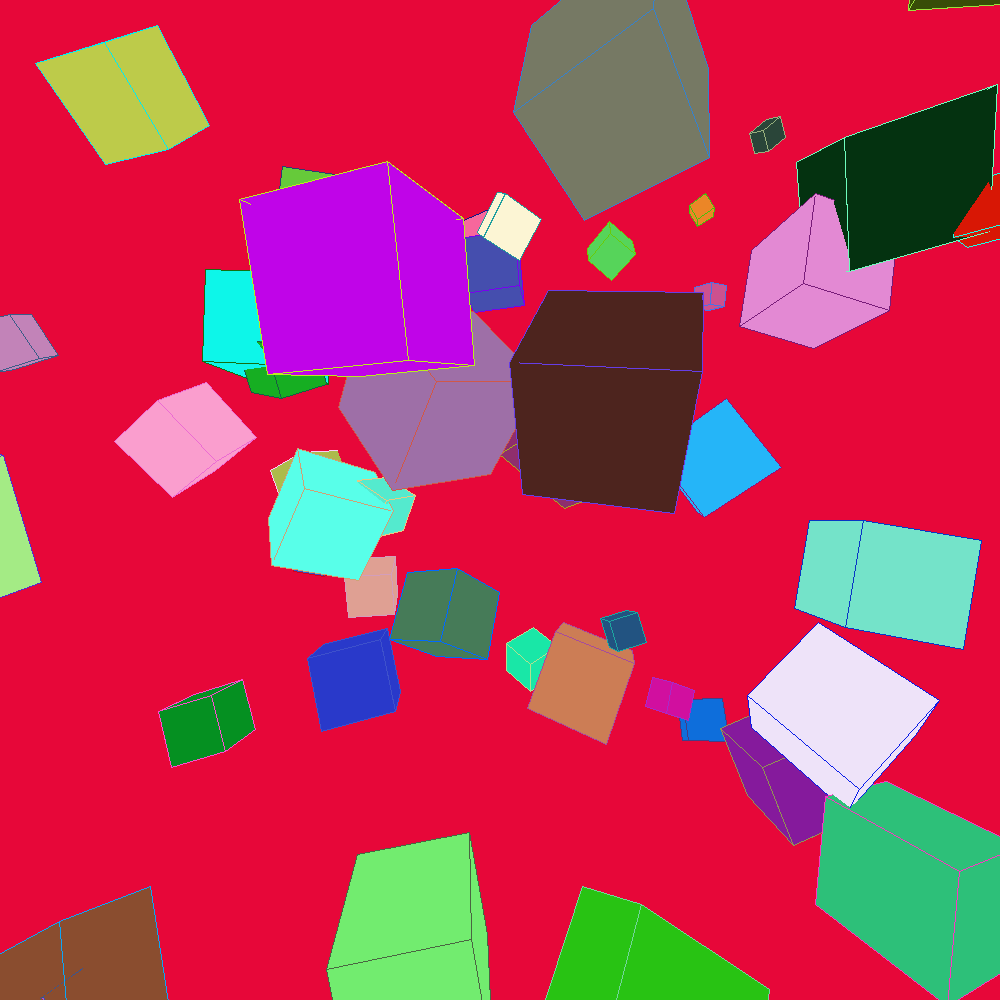

In [ ]:
#initialize objects
cam1 = camera(90,90,(1000,1000),(0,0,0),(0,0,0),(1,1000))
canvas = initialize_2dimage((1000,1000),(r_rgb(),r_rgb(),r_rgb()))
height_map = np.zeros([1000,1000])-1000
mesh = create_cube_mesh(100, (-600,0,758),(r_rotation(),r_rotation(),r_rotation()))

for _ in range(50):
    canvas = most_of_cube_rendering(canvas, height_map, cam1, create_cube_mesh(r_size(), (r_distance(),r_distance(),r_distance_z()),(r_rotation(),r_rotation(),r_rotation())), (r_rgb(),r_rgb(),r_rgb()), (r_rgb(),r_rgb(),r_rgb()))


save_image(canvas, "perfect image")

Note to self use Cython to make the program run faster when I am done

Places to speed up
 - clipping
 - perspective projection 
 - back culling
 - making the screen space function not do any of the rounding
 - everything in rasterdization